# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

import gc
import random

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#clean cuda
gc.collect()
torch.cuda.empty_cache()
torch.backends.cuda.max_split_size_mb = 0  # Set to 0 to disable splitting

In [2]:
# load mnist
dataset = datasets.MNIST(root='./data', download=True,
                       transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))

BATCH_SIZE = 512

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# DCGAN Architecture and custom functions
same architecture as radford2015

In [3]:
D_CONV_DIM = 64
G_CONV_DIM = 64
Z_SIZE = 100

# number of color channels in the images. For grayscale images this is 1
nc = 1
# number of gpu's available
ngpu = 1
# input noise dimension
nz = Z_SIZE
# number of generator filters
ngf = G_CONV_DIM
#number of discriminator filters
ndf = D_CONV_DIM

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [4]:
def refresh_bar(bar, epoch, loss_D, loss_G):
    bar.update()
    bar.set_description("Epoch: {}, Loss D: {:.4f}, Loss G: {:.4f}".format(epoch, loss_D, loss_G))
    bar.update()

In [79]:
def recon_error(generator, x, z=None):
    if z is None:
        z = torch.randn(x.size(0), Z_SIZE, 1, 1, device=device)
    output = generator(z)
    
    # Calculate the squared L2 norm of the difference between output and x
    loss = torch.norm(output - x, p=2)**2
    return loss.item()/784

def measurement_error(generator, Y, W, phase_perturbation=False, case_3=False, z=None):
    if z is None:
        z = torch.randn(Y.size(0), Y.size(1), 1, 1, device=device) 
    output = generator(z).squeeze(1)        # Generate output from the GAN generator

    W = W.to(device)

    # Calculate the product of matrix W and gan output
    WG = torch.matmul(output.view(output.size(0), -1),W)


    if case_3:
        WG = torch.abs(WG)

    if phase_perturbation:
        Y=torch.abs(Y)

    # Calculate the squared L2 norm of the difference between WG and Y
    loss = torch.norm(WG - Y, p=2)**2
    
    return loss.item()/Y.size(0)


In [7]:
def my_loss(Y, z, generator, W, phase_noise=True, alpha=None, device=device):
    x_hat = generator(z)
    x_hat = x_hat.view(-1, 784) 
    W = W.to(device)

    y_hat = torch.mm(x_hat,W).squeeze(0)
    alpha = 0.1 if alpha is None else alpha

    if phase_noise:
        loss = torch.norm(torch.abs(Y) - torch.abs(y_hat), 2)**2 + alpha * torch.norm(z, 2)**2
    else:
        loss = torch.norm(Y - y_hat, 2)**2 + alpha * torch.norm(z, 2)**2
    return loss

In [8]:
def train(generator, discriminator, dataloader, epochs, lr, beta1, beta2, model_name):
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
    optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
    criterion = nn.BCELoss()

    fake_label = 0
    real_label = 1

    bar = tqdm(range(epochs), position=0)
    for epoch in range(epochs):
        for i, data in enumerate(dataloader):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            discriminator.zero_grad()
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), real_label, device=device).float()

            output = discriminator(real_cpu)
            
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, Z_SIZE, 1, 1, device=device)

            fake = generator(noise)
            label.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            generator.zero_grad()
            label.fill_(real_label) 
            output = discriminator(fake)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            
            refresh_bar(bar, epoch, errD.item(), errG.item())


    if epoch == 99 or (epoch+1)%10==0:
        torch.save(generator.state_dict(), model_name+'_Z='+str(Z_SIZE) +'_generator.pth')
        torch.save(discriminator.state_dict(), model_name+'_Z='+str(Z_SIZE) + '_discriminator.pth')

# Bora-like approach

In [9]:
LATENT_SIZES = [100,200,300]

for Z_SIZE in LATENT_SIZES:
    generator = Generator(ngpu, nc, Z_SIZE, ngf).to(device)
    discriminator = Discriminator(ngpu, nc, ndf).to(device)
    train(generator, discriminator, dataloader, 200, 0.0002, 0.5, 0.999, 'bora_mnist_gan')

Epoch: 0, Loss D: 0.5196, Loss G: 4.2839:  48%|████▊     | 95/200 [00:35<00:38,  2.72it/s]

KeyboardInterrupt: 

### Evaluate Bora Models

In [10]:
#import the W matrices and noise vectors
W_10=np.load('W_10.npy')
W_25=np.load('W_25.npy')
W_50=np.load('W_50.npy')
W_100=np.load('W_100.npy')
W_200=np.load('W_200.npy')
W_300=np.load('W_300.npy')

#convert the W and noise vectors to tensors
W_10=torch.tensor(W_10, dtype=torch.float32)
W_25=torch.tensor(W_25, dtype=torch.float32)
W_50=torch.tensor(W_50, dtype=torch.float32)
W_100=torch.tensor(W_100, dtype=torch.float32)
W_200=torch.tensor(W_200, dtype=torch.float32)
W_300=torch.tensor(W_300, dtype=torch.float32)

In [12]:
# load all dataset from the dataloader
data = []
for i, d in enumerate(dataloader):
    data.append(d[0])
data = torch.cat(data, dim=0)
data_full= data.to(device)

Epoch: 0, Loss D: 0.5196, Loss G: 4.2839:  48%|████▊     | 96/200 [01:28<01:35,  1.09it/s]


torch.Size([4, 28, 28])


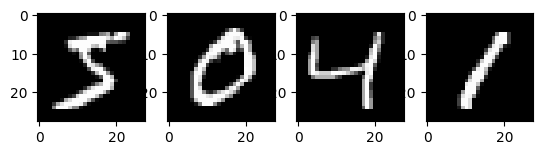

In [13]:
#print the 1st 4 mnist digits

data=data_full[:4].squeeze(1)

print(data.size())

plt.figure()
plt.subplot(141)
plt.imshow(data[0].squeeze().detach().cpu().numpy(), cmap='gray')
plt.subplot(142)
plt.imshow(data[1].squeeze().detach().cpu().numpy(), cmap='gray')
plt.subplot(143)
plt.imshow(data[2].squeeze().detach().cpu().numpy(), cmap='gray')
plt.subplot(144)
plt.imshow(data[3].squeeze().detach().cpu().numpy(), cmap='gray')
plt.show()

### optimize bora loss w.r.t. z

In [ ]:
# clean cuda memory
torch.cuda.empty_cache()

In [98]:
combo=[(50,W_50,Y_50,2),(100,W_100,Y_100,3),(200,W_200,Y_200,4),(300,W_300,Y_300,5)]

Z_SIZE=200
W=W_100

print('Size')
print('Z:', Z_SIZE, ' M:',W.size(1))

generator = Generator(ngpu, nc, Z_SIZE, ngf).to(device)
generator.load_state_dict(torch.load('bora_mnist_gan_Z='+str(Z_SIZE) +'_generator.pth'))
generator.eval()

z=torch.randn(1, Z_SIZE, 1, 1, device=device, requires_grad=True)
x_hat = generator(z).squeeze(1)

Y=torch.mm(x_hat.view(1,-1),W.to(device)).squeeze(0)

Z_ITERS=20000
LR=0.05
LAMBDA=1

z=torch.randn(1, Z_SIZE, 1, 1, device=device, requires_grad=True)
optimizer = optim.NAdam([z], lr=LR, betas=(0.8, 0.999))
z_bar=tqdm(range(Z_ITERS), position=0)

best_loss=1000000000
stuck_counter=0

print('opt for z')
for i in range(Z_ITERS):
    optimizer.zero_grad()
    loss=my_loss(Y, z, generator, W, phase_noise=False, alpha=LAMBDA)
    if loss<best_loss:
        best_loss=loss
        stuck_counter=0
    else:
        stuck_counter+=1
    if stuck_counter>1000:
        break

    loss.backward(retain_graph=True)
    optimizer.step()
    z_bar.set_description("Loss: {:.4f}".format(loss.item()))
    z_bar.update()

z_opt=z.detach()

torch.save(z_opt, 'z_opt_Z='+str(Z_SIZE)+'_NAdam.pth')

Size
Z: 200  M: 100


Loss: 56883.9453:   0%|          | 0/20000 [00:00<?, ?it/s]

opt for z


Loss: 243.2289:  25%|██▍       | 4991/20000 [01:45<03:22, 74.21it/s]  

Loss: 243.2289:  25%|██▍       | 4992/20000 [01:55<03:22, 74.21it/s]

In [100]:
Z_ITERS=20000
LR=0.1
LAMBDA=1

z_phase=torch.randn(1, Z_SIZE, 1, 1, device=device, requires_grad=True)
optimizer = optim.NAdam([z_phase], lr=LR, betas=(0.5, 0.999),weight_decay=0.01,momentum_decay=0.001)
z_bar=tqdm(range(Z_ITERS), position=0)

best_loss=1000000000
stuck_counter=0

print('opt for z_phase:')
for i in range(Z_ITERS):
    optimizer.zero_grad()
    loss=my_loss(Y, z_phase, generator, W, phase_noise=True, alpha=LAMBDA)

    if loss<best_loss:
        best_loss=loss
        stuck_counter=0
    else:
        stuck_counter+=1
    if stuck_counter>1000:
        break

    loss.backward(retain_graph=True)
    optimizer.step()

    z_bar.set_description("Loss: {:.4f}".format(loss.item()))
    z_bar.update()

z_opt_phase=z_phase.detach()

torch.save(z_opt_phase, 'z_opt_phase_Z='+str(Z_SIZE)+'_NAdam.pth')

Loss: 18036.6074:   0%|          | 3/20000 [00:00<16:16, 20.48it/s]

opt for z_phase:


Loss: 700.9225:  43%|████▎     | 8640/20000 [01:36<02:03, 91.99it/s]  

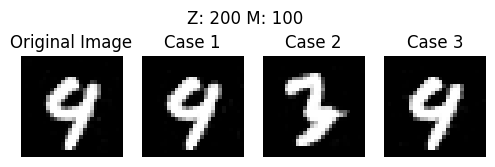

ME - Case 1: 0.6125947570800782
ME - Case 2: 1673.301875
ME - Case 3: 2.2599102783203127


Loss: 700.9225:  43%|████▎     | 8641/20000 [01:55<02:03, 91.99it/s]

In [101]:
plt.figure(figsize=(6,2))
plt.subplot(141)
plt.imshow(x_hat.squeeze().detach().cpu().numpy(), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(142)
plt.imshow(generator(z_opt).squeeze().detach().cpu().numpy(), cmap='gray')
plt.title('Case 1')
plt.axis('off')
plt.subplot(143)
plt.imshow(generator(torch.abs(z_opt)).squeeze().detach().cpu().numpy(), cmap='gray')
plt.title('Case 2')
plt.axis('off')
plt.subplot(144)
plt.imshow(generator(z_opt_phase).squeeze().detach().cpu().numpy(), cmap='gray')
plt.title('Case 3')
plt.axis('off')
plt.suptitle(f'Z: {Z_SIZE} M: {W.size(1)}')
plt.show()

print('ME - Case 1:', measurement_error(generator,Y,W,phase_perturbation=False, z=z_opt))
print('ME - Case 2:', measurement_error(generator,Y,W,phase_perturbation=True, case_3=False,z=z_opt))
print('ME - Case 3:', measurement_error(generator,Y,W,phase_perturbation=True, case_3=True, z=z_opt_phase))
    